# Use Python web scraping technique to analyze U.S.-China trade deficit 

## Introduction

Web scraping is an important skill to collect data for various data science projects. In this work, we use Python-based web scraping technique to analyze U.S.-China trade deficit. Important skills we will learn through this work include: (1), scrape web data using Python `requests` and `beautifulsoup` libraries; (2) transform HTML table data into Pandas `dataframe`; and (3) visualize the data with Python `matplotlib` and `seaborn` libraries.

## The data: U.S.-China trade deficit

To practice the web scraping skills, we will use the data on U.S. trade in goods with China, which is publicly available through the [U.S. Census Bureau](https://www.census.gov/foreign-trade/balance/c5700.html). The website listed the trade data for 34 years (from 1985 to 2018). The data we are interested in reside in multiple tables, and the data for each year is listed in a separate table, which includes into 12 rows for each month. The trade data reports three categories: `Exports` (U.S. goods to China), `Imports` (China goods to U.S.), and `Balance` (which is equal to `Exports` - `Imports`). A negative `Balance` indicates the imports from oversea exceeds the exports, and it is formally called [`Deficit`](https://www.investopedia.com/terms/t/trade_deficit.asp).


The following image show you the U.S.-China trade data in 2018 (as of this writing, only data for this first three months of 2018 are available).
 

<img src="images/US_China_trade_2018.png">

## HTML `table`

We can see that the data we are interested in is presented in a table, as shown above. Before diving into the scraping process of the data, it is important for us to understand the structure of HTML `table`. Let's reproduce the first two rows we saw above with the following `html` code.

<img src="images/HTML_table2.png">

Then we got the table as shown as follows:

<img src="images/HTML_table_result.png">

You can check it out how I got the table on your own through the [w3schools Try Editor](https://www.w3schools.com/code/tryit.asp?filename=FRCG3WFLVE42).

If you are new to HTML documents, here are some basics (with major focus on HTML table):

* All HTML documents must start with a document type declaration: `<!DOCTYPE html>`.

* The HTML document itself begins with `<html>` and ends with `</html>`.

* The visible part of the HTML document is between `<body>` and `</body>`.

* An HTML element usually consists of a `start tag` and `end tag`, with the content inserted in between. For example, table is defined by `<table>` table content goes here, ... `<\table>`, where `<table>` is the `start tag`, and `<\table>` is the `end tag`.

* The HTML `<tbody>` element groups the body content in a table.

* The HTML `<th>` element defines a table heading.

* The HTML `<tr>` element defines a table row.
    
* The HTML `<td>` element defines a table data, e.g., `9,835.3` in our example table above.

For more informed introduction to `HTML`, the readers are referred to [w3schools](https://www.w3schools.com/html/).

## Web Scraping using Python

There are several ways to scrape data from web page by Python, and we are going to use the [`requests`](http://docs.python-requests.org/en/master/) and [`beautifulsoup`](https://www.crummy.com/software/BeautifulSoup/) libraries. We divide the scraping process into three steps:

> 1. We use `requests` to `get` the response of the web page by providing the web page URL. 
> 2. We will parse the response by the `html.parser` provided by `BeautifulSoup`
> 3. We will extract the table data and convert it into Pandas `DataFrame`

In [1]:
# import modules
from requests import get # `get` is used to get the reponse of the webpage
from bs4 import BeautifulSoup

## step 1: get the reponse from the web page
# the url address
url= 'https://www.census.gov/foreign-trade/balance/c5700.html'
# the object returned by the webpage is called 'response'
response = get(url)

## step 2: parse the reponse `text` by using BeautifulSoup
# two arguments: (a) the HTML string to be parsed, and (b) the name of a parser, here we use 'html.parser'.
parser = BeautifulSoup(response.text, 'html.parser')

To this point, we have the parsed HTML content saved in the `parser` object. Next we want to extract all tables by finding their tag `<table>`. We are going to use the `find_all()` method, which extracts a collection of HTML elements.

In [2]:
# we find all tables in the html web page
tables=parser.find_all('table')

There are 34 tables as for 34 years data from 1985 to 2018. We can verify that we successfully retrieve all tables by counting the number of tables

In [3]:
num_tables = len(tables)
num_tables

34

Cool! We got all tables. Next we need to transform HTML table data into Pandas `DataFrame`. We are going to save data in each table into a separate `DataFrame`. We will automate this process by a function. The flow chart is
> 1. We first find all rows inside the table with the `find_all()` method with argument `tr`.
> 2. For each row, we need to compute the `length` of data cell by `find_all()` method with argument `td`.
> 3. If `length` is equal to zero, indicating the header row. We will extract the text as the dataframe column names.
> 4. If `length` is larger than zero, indicating the data row. We will extract the text as the dataframe data.

In [4]:
import pandas as pd

## step 3: iterate each table and extract the data
def html_table_to_dataframe(table):
	header = [] # used to save the column names of the table
	data_list = [] # a list of lists, used to save the actual table data
    # we find all rows
	for row in table.find_all('tr'):
        # for each row, we check the length of the row, or number of data cells in that row
		length =len(row.find_all('td'))
        
        # length is equal to 0, it is the header row, we also convert all string to be lower case
		if length == 0:		# the header row
			header_info = row.find_all('th')
			header = [header_info[i].get_text().lower() for i in range(len(header_info))]
            
        # length is not equal to zero, then data row, and we need to extract the data with the get_text() method
		if length > 0:	# the table data
			data_info = row.find_all('td')
			col = [data_info[i].get_text() for i in range(length)]
			data_list.append(list(col)) 
            
    # we skip the last row 'TOTAL XXXX' of each table        
	df=pd.DataFrame(data_list[:-1],columns=header)
    
	return df

Next we will transform/extract all tables with a single `for` loop, and we will save the output dataframes into a dataframe list `df_list[]`.

In [74]:
df_list = [] # a list of dataframes
for table in tables:
	table_yearly = html_table_to_dataframe(table)
	df_list.append(table_yearly) 

Let's do a sanity check to make sure we can get all table data as expected. We will print out the first table for year 2018 and the last table for year 1985 (Note that we intentionally discarded the last row `TOTAL XXXX` for all tables).

In [75]:
df_list[0] # the first table in the web page

,month,exports,imports,balance
0,January 2018,"9,835.3","45,788.0","-35,952.8"
1,February 2018,"9,806.1","39,067.6","-29,261.5"
2,March 2018,"12,382.1","38,256.7","-25,874.6"


In [76]:
df_list[-1] # the last table in the web page

,month,exports,imports,balance
0,January 1985,319.2,293.1,26.1
1,February 1985,222.7,281.0,-58.3
2,March 1985,239.5,293.0,-53.5
3,April 1985,265.6,283.3,-17.7
4,May 1985,329.3,295.1,34.2
5,June 1985,280.9,348.7,-67.8
6,July 1985,383.1,344.4,38.7
7,August 1985,320.9,311.8,9.1
8,September 1985,339.1,391.8,-52.7
9,October 1985,377.1,385.5,-8.4


Next we are going to concatenate 34 dataframes into a single one. We will reverse the order of `df_list` before applying the `pd.concat()` method, so that the data will appear in the chronological order. 

In [88]:
trade_data = pd.concat(reversed(df_list), ignore_index=True)
trade_data

,month,exports,imports,balance
0,January 1985,319.2,293.1,26.1
1,February 1985,222.7,281.0,-58.3
2,March 1985,239.5,293.0,-53.5
3,April 1985,265.6,283.3,-17.7
4,May 1985,329.3,295.1,34.2
5,June 1985,280.9,348.7,-67.8
6,July 1985,383.1,344.4,38.7
7,August 1985,320.9,311.8,9.1
8,September 1985,339.1,391.8,-52.7
9,October 1985,377.1,385.5,-8.4


HOORAY! We have successfully scraped the table data from the [U.S. Census Bureau](https://www.census.gov/foreign-trade/balance/c5700.html) website and saved them into Pandas DataFrame.

## Exploratory Data Analysis

### Data Cleaning

Before we are able to visualize the data, we have to take care of several issues in our dataframe `trade_data`:

* We need to remove the comma `,` sign in our numerical data.

In [89]:
cols = trade_data.columns
for column in cols:
    trade_data[column]=trade_data[column].apply(lambda x: x.strip()) # trim the space on both side of the string
    trade_data[column]=trade_data[column].apply(lambda x: x.replace(",", "")) # replace ',' with empty space

* We want to split the 'month' column (e.g., `January 1985`) into two columns `month` and `year` (e.g., `January` and `1985`).

In [90]:
trade_data['Month']=trade_data['month'].apply(lambda x: x.strip().split(" ")[0])
trade_data['year']=trade_data['month'].apply(lambda x: x.strip().split(" ")[-1])
# drop the duplicate column "month"
trade_data=trade_data.drop('month',axis=1)
# rename the column "Month" to be "month", "balance" to be "deficit"
trade_data.rename(columns = {'Month':'month', 'balance':'deficit'}, inplace = True)
# reorder the columns
new_cols = ['year','month', 'exports', 'imports', 'deficit']
us_china_trade_data = pd.DataFrame()
for col in new_cols:
    us_china_trade_data[col] = trade_data[col]
us_china_trade_data.head()

,year,month,exports,imports,deficit
0,1985,January,319.2,293.1,26.1
1,1985,February,222.7,281.0,-58.3
2,1985,March,239.5,293.0,-53.5
3,1985,April,265.6,283.3,-17.7
4,1985,May,329.3,295.1,34.2


* The data type is `object` or string, we need to convert it to `float` or `int`.

In [91]:
us_china_trade_data.dtypes

year       object
month      object
exports    object
imports    object
deficit    object
dtype: object

In [92]:
float_cols = ['exports', 'imports', 'deficit'] # these 3 columns will have 'float' data type
for column in float_cols:
    us_china_trade_data[column]=us_china_trade_data[column].astype(float)
    
us_china_trade_data['year']=us_china_trade_data['year'].astype(int) # the 'year' column will have int data type
us_china_trade_data.dtypes

year         int64
month       object
exports    float64
imports    float64
deficit    float64
dtype: object

* We want to map month (e.g., `December`) to numerical number (e.g., `12`). To achieve this, we create a Python dictionary, and use the pd.map() method.

In [93]:
month_dict = {
    "January": 1,
    "February": 2,
    "March": 3,
    "April": 4,
    "May": 5,
    "June": 6,
    "July": 7,
    "August": 8,
    "September": 9,
    "October": 10,
    "November": 11,
    "December": 12
}

us_china_trade_data['month']=us_china_trade_data['month'].map(month_dict)
us_china_trade_data

,year,month,exports,imports,deficit
0,1985,1,319.2,293.1,26.1
1,1985,2,222.7,281.0,-58.3
2,1985,3,239.5,293.0,-53.5
3,1985,4,265.6,283.3,-17.7
4,1985,5,329.3,295.1,34.2
5,1985,6,280.9,348.7,-67.8
6,1985,7,383.1,344.4,38.7
7,1985,8,320.9,311.8,9.1
8,1985,9,339.1,391.8,-52.7
9,1985,10,377.1,385.5,-8.4


In [94]:
us_china_trade_data.dtypes

year         int64
month        int64
exports    float64
imports    float64
deficit    float64
dtype: object

* There are only 3 months data for 2018, let's discard 2018 trade data.

In [95]:
trade_data = us_china_trade_data[us_china_trade_data['year'] < 2018]
trade_data

,year,month,exports,imports,deficit
0,1985,1,319.2,293.1,26.1
1,1985,2,222.7,281.0,-58.3
2,1985,3,239.5,293.0,-53.5
3,1985,4,265.6,283.3,-17.7
4,1985,5,329.3,295.1,34.2
5,1985,6,280.9,348.7,-67.8
6,1985,7,383.1,344.4,38.7
7,1985,8,320.9,311.8,9.1
8,1985,9,339.1,391.8,-52.7
9,1985,10,377.1,385.5,-8.4


The data is clean now, we are ready to answer several questions by further manipulate the data.

### Analysis of U.S.-China trade deficit

We would like to answer several questions regarding U.S.-China trade by digging into our data.

> Question 1: what's the big picture of U.S.-China trade history?

We can answer this question by (1) grouping the yearly trade data, and (2) plotting a bar plot for the `deficit` among 34 years.

In [101]:
import numpy as np
# we group the column data by based on the 'year' column
trade_data_yearly_grouped=trade_data.groupby(['year'])
# we apply the np.sum() function to summarize the value for each year
trade_data_yearly=trade_data_yearly_grouped.agg(np.sum)
# we reorder the data
trade_data_yearly=trade_data_yearly[['exports', 'imports', 'deficit']]
# let's convert the unit from million dollar to billion dollar by '1/1000'
trade_data_yearly = trade_data_yearly.apply(lambda x: x/1000.0)
trade_data_yearly

,exports,imports,deficit
year,,,
1985,3.8557,3.8617,-0.0060
1986,3.1063,4.7710,-1.6647
1987,3.4973,6.2936,-2.7963
1988,5.0216,8.5109,-3.4893
1989,5.7554,11.9897,-6.2343
1990,4.8064,15.2374,-10.4310
1991,6.2782,18.9692,-12.6910
1992,7.4185,25.7275,-18.3090
1993,8.7629,31.5399,-22.7770


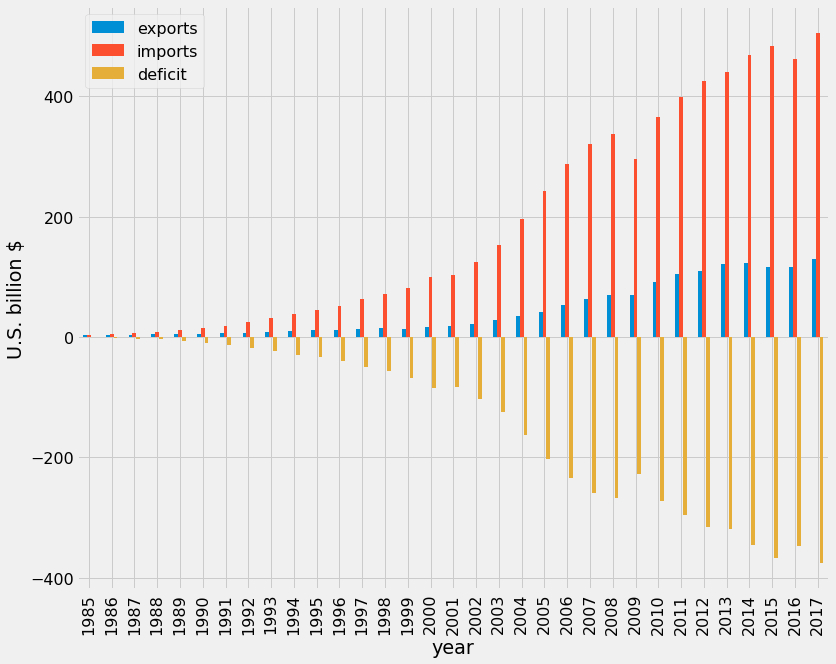

In [126]:
import matplotlib.pyplot as plt
%matplotlib inline
# Pick a style
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 16

ax = trade_data_yearly[['exports', 'imports', 'deficit']].plot.bar(figsize=(12, 10));
ax.set_ylabel('U.S. billion $');

Although there is a steady increase of U.S. exports to China, the imports from China is much larger than the exports (a few times larger). As a result, the trade deficit increases year by year. Specifically, the trade deficit hit 200 billion U.S. dollar at 2005, and it was about 375 billion at 2017. That's why U.S. President Trump really doesn't like the trade deal with China, and wants to cut the deficit by \$200 billion by 2020.

Let's further look at the numbers:

In [127]:
maximum_trade_deficit = trade_data_yearly['deficit'].min()
maximum_trade_deficit

maximum_trade_deficit_year = trade_data_yearly['deficit'].idxmin()
maximum_trade_deficit_year
print("Maximum trade deficit: {0:8.3f} (U.S. billion $), at the year: {1:4d}".format(maximum_trade_deficit, maximum_trade_deficit_year))

Maximum trade deficit: -375.228 (U.S. billion $), at the year: 2017


In [128]:
trade_std = trade_data_yearly['deficit'].std()
print("The deviation of trade deficit from 1985 to 2017 is about: {0:8.3f} (U.S. billion $)".format(trade_std))

The deviation of trade deficit from 1985 to 2017 is about:  132.798 (U.S. billion $)


> Question 2:

* Let's group the yearly data by summarizing the 12-month data.  

,year,exports,imports,deficit
year,,,,
1985,1985,3855.7,3861.7,-6.0
1986,1986,3106.3,4771.0,-1664.7
1987,1987,3497.3,6293.6,-2796.3
1988,1988,5021.6,8510.9,-3489.3
1989,1989,5755.4,11989.7,-6234.3
1990,1990,4806.4,15237.4,-10431.0
1991,1991,6278.2,18969.2,-12691.0
1992,1992,7418.5,25727.5,-18309.0
1993,1993,8762.9,31539.9,-22777.0


In [62]:
import matplotlib.pyplot as plt
%matplotlib inline
# Pick a style
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 16

import seaborn as sns

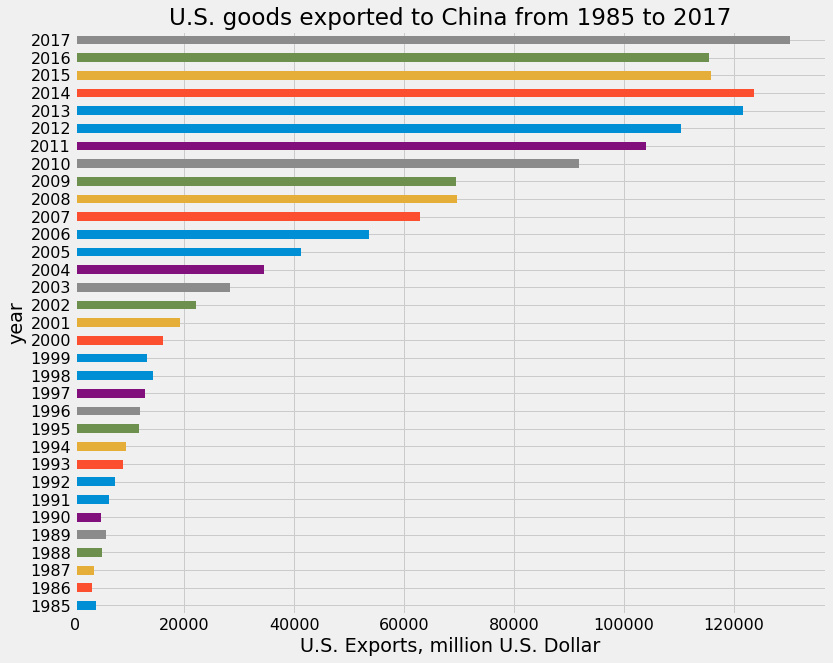

In [63]:
#
ax = trade_data_yearly.plot(kind='barh', x = 'year', y = 'exports', figsize=(12, 10), 
                       title='U.S. goods exported to China from 1985 to 2017',
                      legend=False);
ax.set_xlabel("U.S. Exports, million U.S. Dollar");
ax.set_ylabel("year");

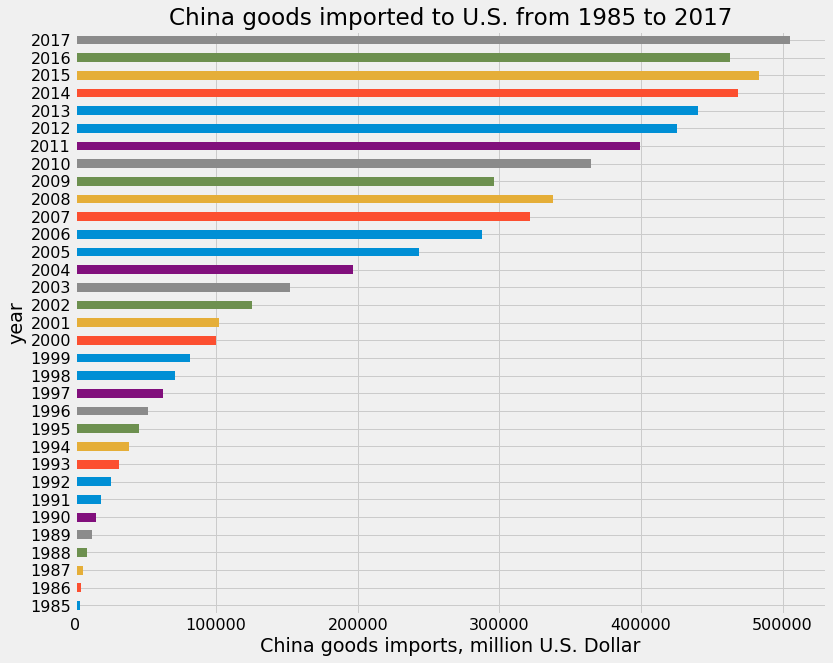

In [64]:
#
ax = trade_data_yearly.plot(kind='barh', x = 'year', y = 'imports', figsize=(12, 10), 
                       title='China goods imported to U.S. from 1985 to 2017',
                      legend=False);
ax.set_xlabel("China goods imports, million U.S. Dollar");
ax.set_ylabel("year");

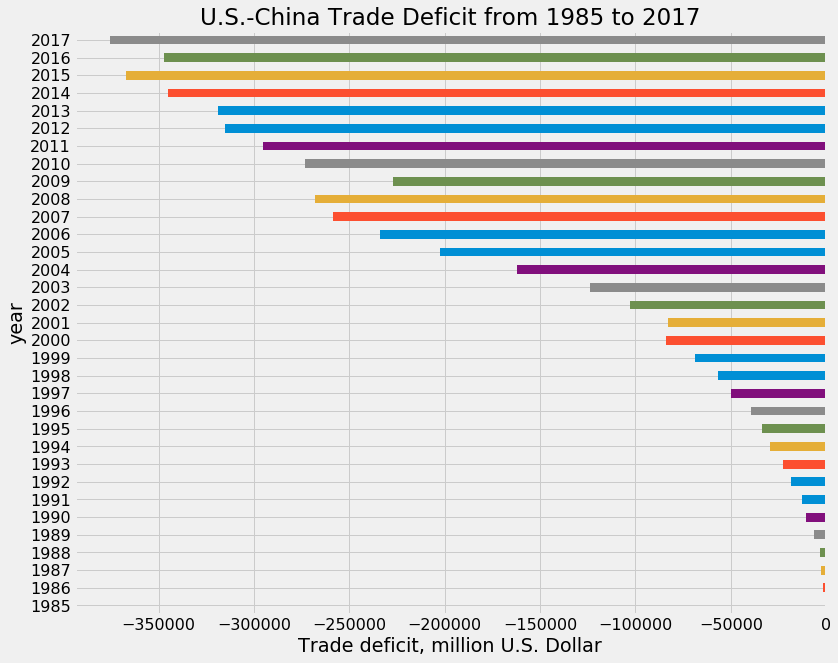

In [65]:
#
ax = trade_data_yearly.plot(kind='barh', x = 'year', y = 'balance', figsize=(12, 10), 
                       title='U.S.-China Trade Deficit from 1985 to 2017',
                      legend=False);
ax.set_xlabel("Trade deficit, million U.S. Dollar");
ax.set_ylabel("year");

In [66]:
#pivot_df = trade_data_yearly.pivot(index='year', columns='exports', values='imports')
#pivot_df

In [67]:
#pivot_df.loc[:,['exports','imports']].plot.bar(stacked=True, color=colors, figsize=(10,7))

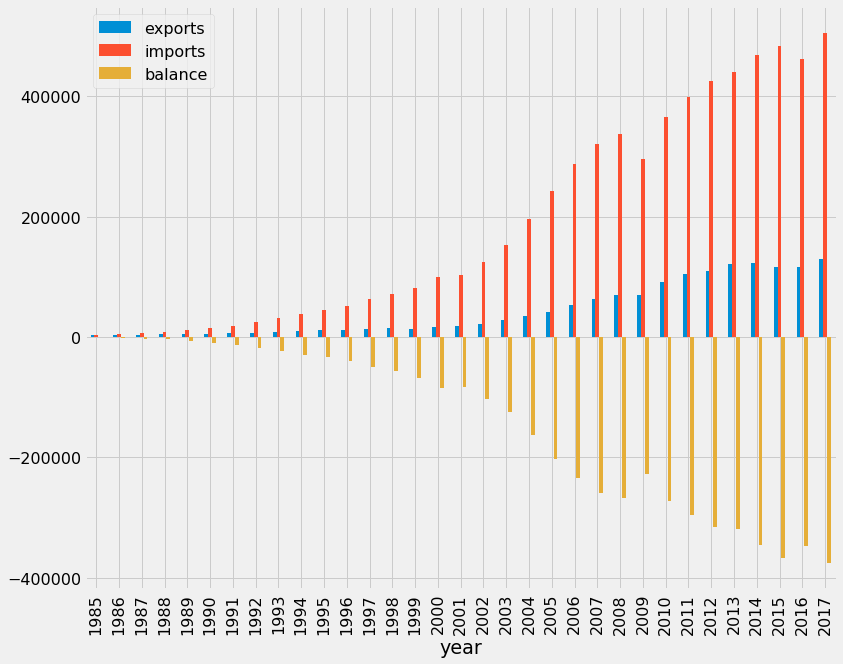